In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import time
import numpy as np
from sys import getsizeof
from math import exp, log
import os
import random
import string
from tqdm import tqdm

from cuckoofilter import CuckooFilter
from cuckoofilter import CountingBloomFilter
from collections import defaultdict

try:
    import seaborn as sns
    sns.set(context='notebook', style='darkgrid',  font='sans-serif', font_scale=1)
except ImportError: #proceed anyway even if user does not have seaborn. 
    pass

## False Positive Rate Comparison

In [2]:
def counting_bloom_and_cuckoo_filter_fpr(capacity, finger_print_size=0.5, bucket_size=4,\
                                         number_of_bytes=100000, alpha=0.75):
    alpha = number_of_bytes / (capacity * finger_print_size * bucket_size)
    
    analytic_bloom_error = exp(-(((number_of_bytes-1)*log(2)**2)/capacity) ) 
    
    analytic_cuckoo_error = 1 / (2**( finger_print_size*alpha*8 - log(2*bucket_size, 2)))#this is estimated from the paper
     
    return analytic_bloom_error, analytic_cuckoo_error

In [3]:
capacities = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]
bloom_fp = []
cuckoo_fp = []

for size in capacities:
    bfp, cfp = counting_bloom_and_cuckoo_filter_fpr(size, finger_print_size=0.5, bucket_size=4, alpha=0.8)
    bloom_fp.append(bfp)
    cuckoo_fp.append(cfp)

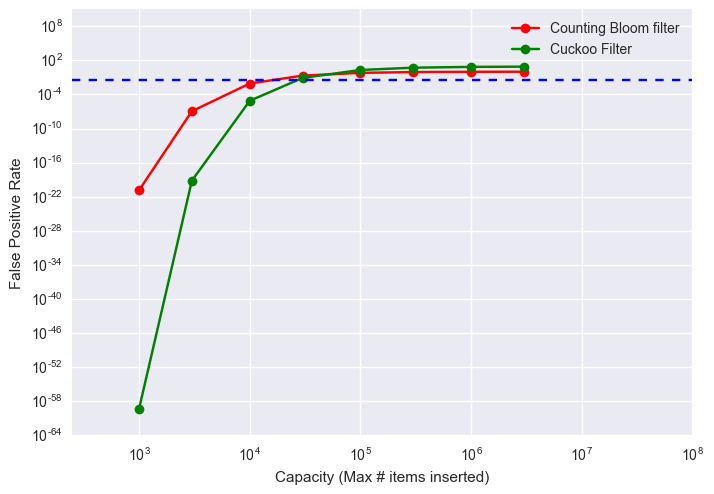

In [4]:
plt.loglog(np.array(capacities), np.array(bloom_fp), "-ro", ms=7, label="Counting Bloom filter")
plt.loglog(np.array(capacities), np.array(cuckoo_fp), "-go", ms=7, label="Cuckoo Filter")
plt.axhline(y=0.03, xmin=0, xmax=1, hold=None, ls="--")
plt.xlim([2.5*10e1, 10e7])
plt.ylim([10e-65, 10e10])
plt.ylabel("False Positive Rate")
plt.xlabel("Capacity (Max # items inserted)")
plt.legend()
plt.savefig('images/false_positive_test.png', bbox_inches='tight')

## Filter Insertion Throughput at Different Occupancy Levels

In [5]:
def return_cuckoo_filter_with_specified_load_factor(capacity, finger_print_size=2, load_factor=0.2):
    c_filter = CuckooFilter(capacity, finger_print_size, bucket_size=2)
    for i in range(int(capacity*6)):
        try:
            item = "".join(random.sample(string.ascii_lowercase, 12))
            c_filter.add(item)
        except Exception('CuckooFilter has filled up!'):
            break
            
        if round(c_filter.get_load_factor(), 2) == round(load_factor, 2):
            return c_filter, c_filter.get_load_factor()
    raise ValueError

def return_bloom_filter_with_specified_load_factor(capacity, percent_to_fill=0.2):
    b_filter = CountingBloomFilter(capacity)
    for i in range(int(percent_to_fill*capacity)):
        item = "".join(random.sample(string.ascii_lowercase, 12))
        b_filter.add(item)
    
    return b_filter, percent_to_fill

In [6]:
load_factors_of_interest = np.linspace(0.1, 0.8, 8)
capacity = 3e4
num_items_to_insert = 500
num_runs = 30
timings_cuckoo = defaultdict(list)
timings_bloom = defaultdict(list)

for load in tqdm(load_factors_of_interest, "current run"):
    for run in tqdm(range(num_runs)):
        c_filt, _ = return_cuckoo_filter_with_specified_load_factor(int(capacity),\
                                                                                 finger_print_size=2, load_factor=load)
        b_filt, _ = return_bloom_filter_with_specified_load_factor(int(capacity), percent_to_fill=load)
        
        start = time.time()
        for item_to_insert in range(num_items_to_insert):
            item = "".join(random.sample(string.ascii_lowercase, 12))
            c_filt.add(item)
        dt_cuckoo = time.time() - start
        timings_cuckoo[load].append(dt_cuckoo)
        
        start = time.time()
        for item_to_insert in range(num_items_to_insert):
            item = "".join(random.sample(string.ascii_lowercase, 12))
            b_filt.add(item)
        dt_bloom = time.time() - start
        timings_bloom[load].append(dt_bloom)

current run: 100%|██████████| 8/8 [10:29<00:00, 102.24s/it]


In [7]:
timings_cuckoo_2 = sorted(timings_cuckoo.items()) #redundant variable, but doing this to make sure this cell can be rerun
timings_bloom_2 = sorted(timings_bloom.items())

load_factors_emp = []
cuckoo_times_array = []
bloom_times_array = []

for key, times in timings_cuckoo_2:
    load_factors_emp.append(key)
    current_y = [np.percentile(times, p) for p in (25, 50, 75)]
    cuckoo_times_array.append(current_y)
    
for key, times in timings_bloom_2:
    current_y = [np.percentile(times, p) for p in (25, 50, 75)]
    bloom_times_array.append(current_y)
    
cuckoo_times_array = np.asarray(cuckoo_times_array)
bloom_times_array = np.asarray(bloom_times_array)

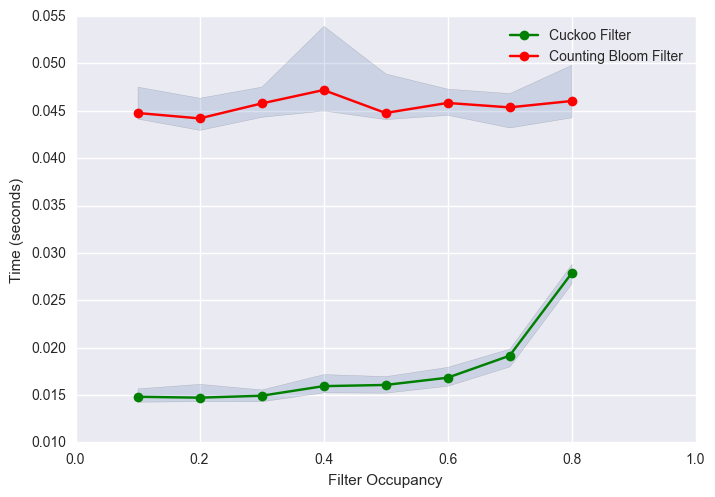

In [8]:
plt.fill_between(load_factors_emp, cuckoo_times_array[:,0], cuckoo_times_array[:,2], alpha=0.2)
plt.plot(load_factors_emp, cuckoo_times_array[:,1], "-go", label="Cuckoo Filter")

plt.fill_between(load_factors_emp, bloom_times_array[:,0], bloom_times_array[:,2], alpha=0.2)
plt.plot(load_factors_emp, bloom_times_array[:,1], "-ro", label="Counting Bloom Filter")


plt.ylabel("Time (seconds)")
plt.xlabel("Filter Occupancy")
plt.xlim([0, 1])
plt.legend()
plt.savefig('images/load_factor.png', bbox_inches='tight')

## Insertion Throughput without Occupancy Changes

In [9]:
def insert_and_time_filter_cuckoo_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    c_filter = CuckooFilter(capacity, 2)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        try:
            c_filter.insert(str(i))
            num_inserted += 1
        except Exception("CuckooFilter has filled up!"):
            break
    elapsed_insertion = time.time() - now
    return c_filter, elapsed_insertion, num_inserted

In [10]:
def insert_and_time_filter_bloom_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    b_filter = CountingBloomFilter(capacity)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        b_filter.add(str(i))
    elapsed_insertion = time.time() - now
    return b_filter, elapsed_insertion

In [11]:
bloom_times = []
cuckoo_times = []

for size in tqdm(capacities):
    
    __, c_time, num_inserted = insert_and_time_filter_cuckoo_filter(int(size))
    cuckoo_times.append(c_time)
    
    __,b_time =  insert_and_time_filter_bloom_filter(num_inserted)
    bloom_times.append(b_time)


100%|██████████| 8/8 [04:37<00:00, 73.01s/it]


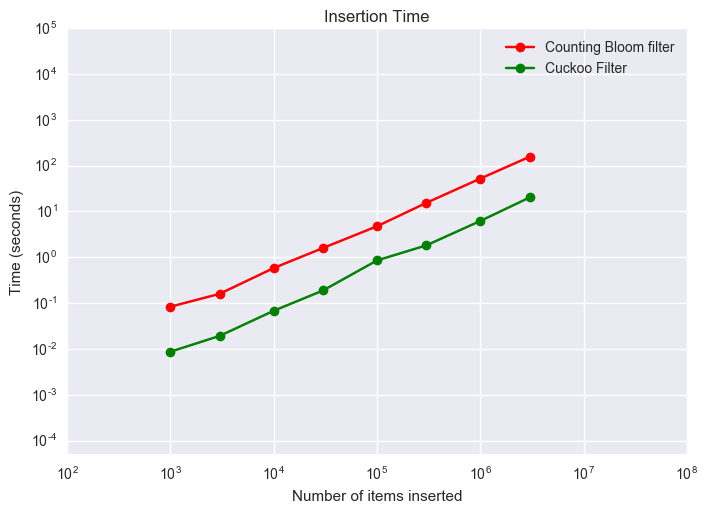

In [12]:
#result from running this once. takes more than 10mins, so not running multiple times. 
plt.loglog(np.array(capacities), np.array(bloom_times), "-ro", ms=7, label="Counting Bloom filter")
plt.loglog(np.array(capacities), np.array(cuckoo_times), "-go", ms=7, label="Cuckoo Filter")
plt.xlim([10e1, 10e7])
plt.ylim([5.0 * 10e-6, 10e4])
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items inserted")
plt.title("Insertion Time")
plt.legend()
plt.savefig('images/insertion_time.pdf', bbox_inches='tight')

# Deletion

In [13]:
def delete_from_cuckoo_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    c_filter, _, _ = insert_and_time_filter_cuckoo_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = c_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        c_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return c_filter, elapsed_time

In [14]:
def delete_from_bloom_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    b_filter, _ = insert_and_time_filter_bloom_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = b_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        b_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return b_filter, elapsed_time

In [15]:
bloom_times_deletion = []
cuckoo_times_deletion = []

for size in tqdm(capacities):
    __,b_time =  delete_from_bloom_filter_and_time(int(size), percent_to_fill=0.9, percent_delete=1.0)
    bloom_times_deletion.append(b_time)
    
    __, c_time = delete_from_cuckoo_filter_and_time(int(size), percent_to_fill=0.9, percent_delete=1.0)
    cuckoo_times_deletion.append(c_time)

100%|██████████| 8/8 [08:51<00:00, 139.44s/it]


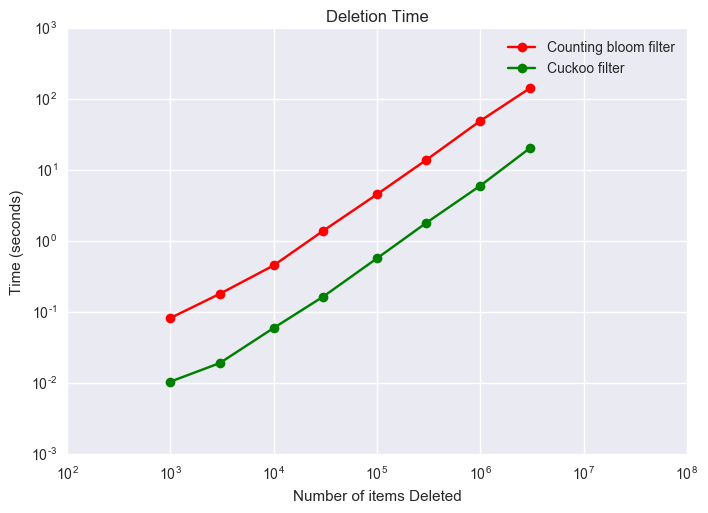

In [16]:
plt.loglog(np.array(capacities), np.array(bloom_times_deletion), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(capacities), np.array(cuckoo_times_deletion), "-go", ms=7, label="Cuckoo filter")
plt.xlim([10e1, 10e7])
plt.ylim([10e-4, 10e2])
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items Deleted")
plt.title("Deletion Time")
plt.legend()
plt.savefig('images/deletion_time.pdf', bbox_inches='tight')